In [1]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator


In [2]:
model_path = '../Potentials/Vacancy_Train_Results/bestF_epoch89_e2_f28_s55_mNA.pth.tar'
chgnet = CHGNet.from_file(model_path)


CHGNet v0.3.0 initialized with 412,525 parameters


In [4]:
calculator = CHGNetCalculator(chgnet, use_device='mps')

CHGNet will run on mps


In [7]:
from ase.io import read, write 
import json 
# parity plot generation
data = read('../Archived_Vasp_Jobs/test_vac_conv.extxyz', format='extxyz', index=':')
# if using atoms objects from extxyz file use this
forces = []
true_forces = []
energies = []
true_energies = []
virials = []
true_virials = []

# Function to check for virial or stress
def get_virial_or_stress(frame):
    if "original_dataset_virial" in frame.info:
        return frame.info["original_dataset_virial"].flatten() / frame.get_volume()
    elif "original_dataset_stress" in frame.info:
        return frame.info["original_dataset_stress"].flatten()
    else:
        return None

k = 0
total_data = len(data)
for atoms in data:
    if k % 10 == 0: # for v-cr-ti set to 10
        atoms.calc = calculator
        temp_true_energy = atoms.info['REF_energy']/len(atoms)
        temp_true_forces = list(atoms.todict()['REF_force'].flatten())
        temp_true_stresses = list(atoms.info['REF_stress'].flatten())
        true_energies.append(temp_true_energy)
        true_forces.append(temp_true_forces)
        true_virials.append(temp_true_stresses)
        forces.append(atoms.get_forces().flatten())
        energies.append(atoms.get_potential_energy()/len(atoms))
        #virials.append(-1*atoms.get_volume()*atoms.get_stress(voigt=False).flatten())
        virials.append(atoms.get_stress(voigt=False).flatten())
        #print(temp_true_stresses)
        #print(-1*atoms.get_volume()*atoms.get_stress(voigt=False).flatten())
        #print('True Energy: ', temp_true_energy, 'Predicted Energy: ', atoms.get_potential_energy()/len(atoms))
        #print('True Forces: ', len(temp_true_forces), 'Predicted Forces: ', len(atoms.get_forces().flatten()))
        #print('True Virials: ', len(temp_true_stresses), 'Predicted Virials: ', len(atoms.get_stress(voigt=False).flatten()))
        # check the size of each array to make sure the true and predicted arrays are the same size
        #print(f"Iteration {k}:")
        #print(f"  Length of forces: {len(forces)}")
        #print(f"  Length of true_forces: {len(true_forces)}")
        #print(f"  Length of energies: {len(energies)}")
        #print(f"  Length of true_energies: {len(true_energies)}")
        #print(f"  Length of virials: {len(virials)}")
        #print(f"  Length of true_virials: {len(true_virials)}")
        k += 1
        print('On iteration: ', k, ' out of ', total_data)
        # check the size of each array to make sure the true and predicted arrays are the same size
        assert len(forces) == len(true_forces)
        assert len(energies) == len(true_energies)
        assert len(virials) == len(true_virials)
    else:
        k += 1
        continue 

On iteration:  1  out of  6425
On iteration:  11  out of  6425
On iteration:  21  out of  6425
On iteration:  31  out of  6425
On iteration:  41  out of  6425
On iteration:  51  out of  6425
On iteration:  61  out of  6425
On iteration:  71  out of  6425
On iteration:  81  out of  6425
On iteration:  91  out of  6425
On iteration:  101  out of  6425
On iteration:  111  out of  6425
On iteration:  121  out of  6425
On iteration:  131  out of  6425
On iteration:  141  out of  6425
On iteration:  151  out of  6425
On iteration:  161  out of  6425
On iteration:  171  out of  6425
On iteration:  181  out of  6425
On iteration:  191  out of  6425
On iteration:  201  out of  6425
On iteration:  211  out of  6425
On iteration:  221  out of  6425
On iteration:  231  out of  6425
On iteration:  241  out of  6425
On iteration:  251  out of  6425
On iteration:  261  out of  6425
On iteration:  271  out of  6425
On iteration:  281  out of  6425
On iteration:  291  out of  6425
On iteration:  301  o

In [9]:
import numpy as np
#conversion_factor = 0.00624150975 # converts kb to eV/anstrom^3
new_forces = np.concatenate(forces, axis=0)
new_true_forces = np.concatenate(true_forces, axis=0)
new_energies = np.asarray(energies)
new_true_energies = np.asarray(true_energies)
new_virials = np.concatenate(virials, axis=0) if virials else None
#new_true_virials = conversion_factor * np.concatenate(true_virials, axis=0) if true_virials else None
new_true_virials = np.concatenate(true_virials, axis=0) if true_virials else None


# Convert numpy arrays to lists
forces_list = new_forces.tolist()
true_forces_list = new_true_forces.tolist()
energies_list = new_energies.tolist()
true_energies_list = new_true_energies.tolist()
virials_list = new_virials.tolist() if virials is not None else None
true_virials_list = new_true_virials.tolist() if new_true_virials is not None else None

# Create a dictionary
data = {
    #"conversion_factor": conversion_factor,
    "forces": forces_list,
    "true_forces": true_forces_list,
    "energies": energies_list,
    "true_energies": true_energies_list,
    "virials": virials_list,
    "true_virials": true_virials_list
}

# Save to JSON file
with open('chgnet_vcrti_vac_parity_plot_data.json', 'w') as json_file:
    json.dump(data, json_file)


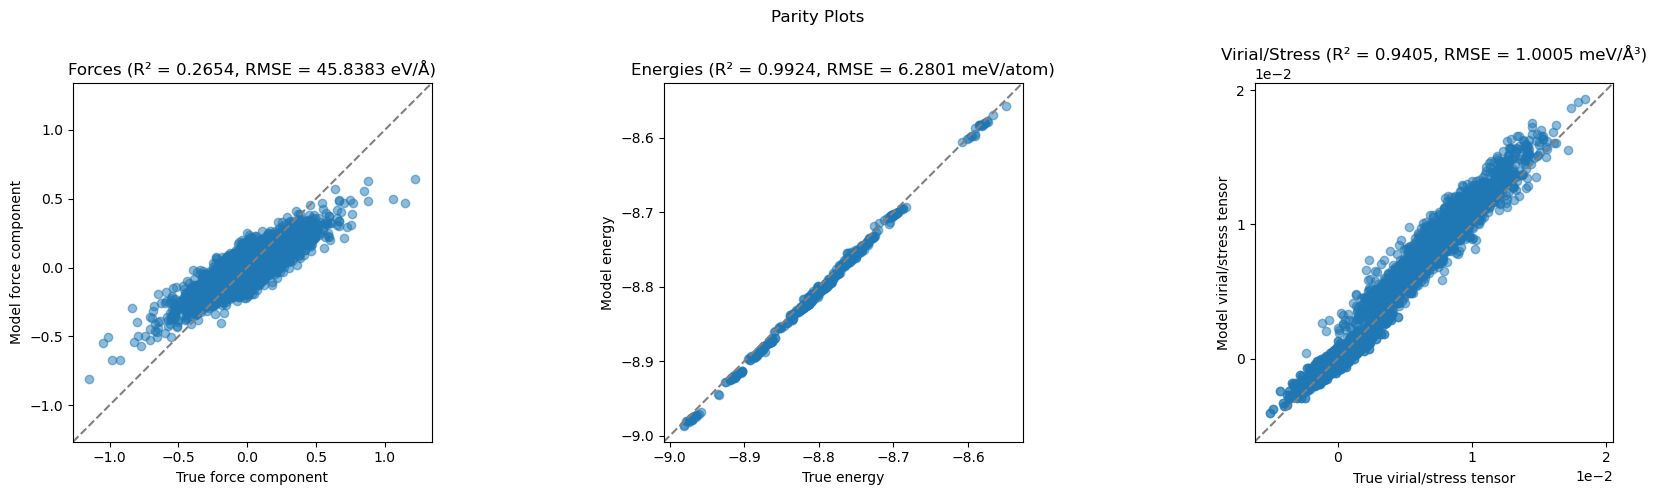

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Calculate R^2 values
r2_forces = r2_score(new_true_forces, new_forces)
r2_energies = r2_score(new_true_energies, new_energies)
r2_virials = r2_score(new_true_virials, new_virials) if new_virials is not None else None

# Calculate RMSE values
rmse_forces = np.sqrt(mean_squared_error(new_true_forces, new_forces))
rmse_energies = np.sqrt(mean_squared_error(new_true_energies, new_energies))
rmse_virials = np.sqrt(mean_squared_error(new_true_virials, new_virials)) if new_virials is not None else None

# Determine the number of plots and figure size
if new_virials is not None:
    n_plots = 3
    fig_width = 18  # Increased width to accommodate all plots
else:
    n_plots = 2
    fig_width = 12

fig, axs = plt.subplots(ncols=n_plots, figsize=(fig_width, 5))

# Force plot
ax = axs[0]
ax.set_xlabel("True force component")
ax.set_ylabel("Model force component")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(new_true_forces, new_forces, alpha=0.5)
ax.set_aspect("equal")
ax.set_title(f"Forces (R² = {r2_forces:.4f}, RMSE = {1E3*rmse_forces:.4f} eV/Å)")

# Ensure the plot is square by setting the same limits for x and y axes
force_lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
    max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
]
ax.set_xlim(force_lims)
ax.set_ylim(force_lims)
ax.set_aspect('equal')  # Ensure the aspect ratio is equal

# Energy plot
ax = axs[1]
ax.set_xlabel("True energy")
ax.set_ylabel("Model energy")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(new_true_energies, new_energies, alpha=0.5)
ax.set_aspect("equal")
ax.set_title(f"Energies (R² = {r2_energies:.4f}, RMSE = {1E3*rmse_energies:.4f} meV/atom)")

# Ensure the plot is square by setting the same limits for x and y axes
energy_lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
    max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
]
ax.set_xlim(energy_lims)
ax.set_ylim(energy_lims)
ax.set_aspect('equal')  # Ensure the aspect ratio is equal

# Virial/Stress plot
if new_virials is not None:
    ax = axs[2]
    ax.set_xlabel("True virial/stress tensor")
    ax.set_ylabel("Model virial/stress tensor")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
    ax.scatter(new_true_virials, new_virials, alpha=0.5)
    ax.set_aspect("equal")
    ax.set_title(f"Virial/Stress (R² = {r2_virials:.4f}, RMSE = {1E3*rmse_virials:.4f} meV/Å³)")

    # Use scientific notation for axis labels
    ax.ticklabel_format(style='sci', scilimits=(-2,2), axis='both')

    # Adjust tick frequency
    ax.locator_params(axis='both', nbins=5)

    # Ensure the plot is square by setting the same limits for x and y axes
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
        max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')  # Ensure the aspect ratio is equal

plt.suptitle("Parity Plots")
plt.tight_layout()

plt.show()

In [9]:
#load the structure 
from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar

structure = Structure.from_file('../Archived_Vasp_Jobs/VCrTi_Vacancies_T3_jobs/structure_0_vac_site_0_end_site_7/POSCAR')
#print(structure)

In [19]:
from chgnet.model import StructOptimizer

opt = StructOptimizer(calc, use_device='mps')
relaxed_structure = opt.relax(structure,fmax=0.01,steps=1000,verbose=True,relax_cell=False)

      Step     Time          Energy          fmax
FIRE:    0 17:41:56     -564.201465        0.694551
FIRE:    1 17:41:56     -564.297535        0.696591
FIRE:    2 17:41:57     -564.478741        0.650442
FIRE:    3 17:41:57     -564.717204        0.572166
FIRE:    4 17:41:58     -564.974473        0.493268
FIRE:    5 17:41:58     -565.200199        0.376240
FIRE:    6 17:41:58     -565.354729        0.293174
FIRE:    7 17:41:59     -565.423462        0.193501
FIRE:    8 17:41:59     -565.409823        0.227050
FIRE:    9 17:41:59     -565.412467        0.222065
FIRE:   10 17:41:59     -565.417454        0.213357
FIRE:   11 17:41:59     -565.424603        0.204611
FIRE:   12 17:41:59     -565.433496        0.191588
FIRE:   13 17:42:00     -565.443529        0.179662
FIRE:   14 17:42:00     -565.454043        0.167351
FIRE:   15 17:42:00     -565.464437        0.149228
FIRE:   16 17:42:00     -565.475192        0.132471
FIRE:   17 17:42:00     -565.485286        0.119612
FIRE:   18 17:

In [20]:
print(relaxed_structure['final_structure'])

Full Formula (Ti6 V38 Cr19)
Reduced Formula: Ti6(V2Cr)19
abc   :  10.426946  10.426946  10.426946
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (63)
  #  SP            a          b          c      magmom
---  ----  ---------  ---------  ---------  ----------
  0  Ti     0.498259   0.002579   0.249278  0.0747313
  1  Ti     0.507084   0.25473    0.005285  0.0746262
  2  Ti     0.510438   0.758483   0.499924  0.0729697
  3  Ti     0.742179  -0.006536   0.003313  0.103499
  4  Ti     0.742153   0.241526   0.750912  0.0705516
  5  Ti     0.738101   0.744133   0.24239   0.10424
  6  V      0.008873  -0.011136   0.006442  0.113557
  7  V      0.0164     0.015065   0.494546  0.0681184
  8  V     -0.00645   -0.003677   0.745018  0.128982
  9  V     -0.009383   0.24191   -0.002414  0.0408828
 10  V      0.019963   0.256875   0.270675  0.0666556
 11  V     -0.002971   0.252169   0.502769  0.094786
 12  V      0.008207   0.259422   0.751769  0.0443041
 13

In [41]:
import json 

data_path = '../Visualization/Job_Structures/Pre_VASP/VCrTi_Fixed_125/NEB_Batch_Total/structure_257_comp_Ti20V98Cr7_vac_site_112/neb_vac_site_112_to_91/results.json'
data = json.load(open(data_path))

In [42]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator

model_path = '../Potentials/Vacancy_Train_Results/bestF_epoch89_e2_f28_s55_mNA.pth.tar'
chgnet = CHGNet.from_file(model_path)
calculator = CHGNetCalculator(chgnet, use_device='mps')

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


In [4]:
print(data['structures'])

dict_keys(['0', '1', '2', '3', '4', '5', '6'])


In [43]:
from chgnet.model.dynamics import StructOptimizer
from pymatgen.core import Structure

relaxer = StructOptimizer(calculator, use_device='mps')

In [44]:
start_structure = Structure.from_dict(data['structures']['0'])
end_structure = Structure.from_dict(data['structures']['6'])

relax_start = relaxer.relax(start_structure, fmax=0.01, steps=1000, verbose=True, relax_cell=False)
relax_end = relaxer.relax(end_structure, fmax=0.01, steps=1000, verbose=True, relax_cell=False)

      Step     Time          Energy          fmax
FIRE:    0 11:52:06    -1081.954681        0.826712
FIRE:    1 11:52:06    -1082.141171        0.823383
FIRE:    2 11:52:06    -1082.491444        0.804066
FIRE:    3 11:52:06    -1082.948738        0.746572
FIRE:    4 11:52:06    -1083.439972        0.685644
FIRE:    5 11:52:07    -1083.899277        0.611810
FIRE:    6 11:52:07    -1084.274620        0.528888
FIRE:    7 11:52:07    -1084.540932        0.447564
FIRE:    8 11:52:08    -1084.699986        0.312484
FIRE:    9 11:52:08    -1084.762661        0.217708
FIRE:   10 11:52:09    -1084.739483        0.304014
FIRE:   11 11:52:09    -1084.746933        0.293452
FIRE:   12 11:52:09    -1084.761005        0.274703
FIRE:   13 11:52:09    -1084.780045        0.243105
FIRE:   14 11:52:10    -1084.802040        0.211984
FIRE:   15 11:52:10    -1084.824982        0.180366
FIRE:   16 11:52:10    -1084.847095        0.171467
FIRE:   17 11:52:10    -1084.866844        0.163646
FIRE:   18 11:

In [45]:
# create the images
from ase.mep import DyNEB
from pymatgen.io.ase import AseAtomsAdaptor

images = [AseAtomsAdaptor.get_atoms(relax_start['final_structure'])]
for i in range(1, 6):
    images.append(AseAtomsAdaptor.get_atoms(relax_start['final_structure']))
images.append(AseAtomsAdaptor.get_atoms(relax_end['final_structure']))

In [54]:
from ase.optimize import FIRE

neb_model_path = '../Potentials/Jan_26_100_Train_Results/bestF_epoch75_e3_f23_s23_mNA.pth.tar'
neb_chgnet = CHGNet.from_file(neb_model_path)
neb_calculator = CHGNetCalculator(neb_chgnet, use_device='mps')

for image in images:
    image.calc = CHGNetCalculator(neb_chgnet, use_device='mps')

neb = DyNEB(images, dynamic_relaxation=True, scale_fmax=2.)
neb.interpolate(mic=True)
lbfgs = FIRE(neb)  # here I am not making a trajectory file

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps
CHGNet will run on mps


In [55]:
lbfgs.run(fmax=0.01, steps=250)

      Step     Time          Energy          fmax
FIRE:    0 13:11:49    -1081.171593        0.492550
FIRE:    1 13:11:50    -1081.183891        0.473978
FIRE:    2 13:11:51    -1081.207661        0.432234
FIRE:    3 13:11:52    -1081.239471        0.361892
FIRE:    4 13:11:54    -1081.275539        0.302897
FIRE:    5 13:11:55    -1081.315865        0.254150
FIRE:    6 13:11:58    -1081.357964        0.204727
FIRE:    7 13:12:01    -1081.398170        0.237381
FIRE:    8 13:12:03    -1081.436249        0.263229
FIRE:    9 13:12:04    -1081.471607        0.268688
FIRE:   10 13:12:07    -1081.502472        0.245100
FIRE:   11 13:12:11    -1081.523640        0.209294
FIRE:   12 13:12:15    -1081.537949        0.178193
FIRE:   13 13:12:15    -1081.545517        0.150133
FIRE:   14 13:12:21    -1081.556515        0.128887
FIRE:   15 13:12:23    -1081.566566        0.129137
FIRE:   16 13:12:25    -1081.577446        0.114309
FIRE:   17 13:12:30    -1081.586315        0.178958
FIRE:   18 13:

False

In [56]:
post_neb_start = relaxer.relax(images[0], fmax=0.01, steps=1000, relax_cell=False)
post_neb_end = relaxer.relax(images[-1], fmax=0.01, steps=1000, relax_cell=False)


      Step     Time          Energy          fmax
FIRE:    0 13:12:53    -1085.070007        0.009229
      Step     Time          Energy          fmax
FIRE:    0 13:12:54    -1085.321301        0.009391


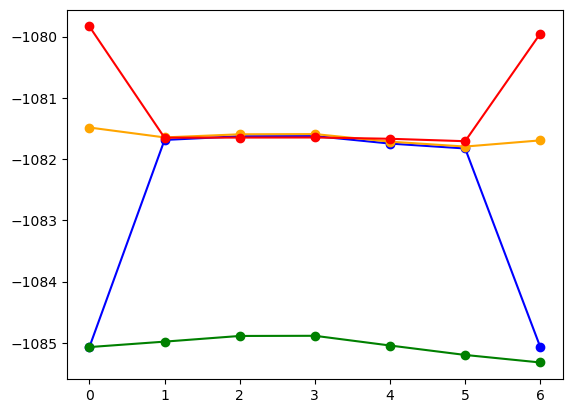

In [57]:
import matplotlib.pyplot as plt 
energies = [image.get_potential_energy() for image in images]
energies[0] = post_neb_start['trajectory'].energies[0]
energies[-1] = post_neb_start['trajectory'].energies[-1]
original_energies = [-1085.0698890686035, -1084.9809608459473, -1084.8882484436035, -1084.8855285644531, -1085.0441093444824, -1085.1984329223633, -1085.3213005065918]
original_neb_energies = [-1081.484260559082, -1081.6457977294922, -1081.5949478149414, -1081.591163635254, -1081.714859008789, -1081.7951545715332, -1081.6942825317383]
image_num = [i for i in range(7)]

plt.plot(image_num, energies, '-o', color='blue')
plt.plot(image_num, original_energies, '-o', color='green')
plt.plot(image_num, original_neb_energies, '-o', color='orange')
plt.plot(image_num, data['energies'].values(), '-o', color='red')
plt.show()

In [49]:
import numpy as np
barrier = np.max(np.array(energies)) - energies[0]
print(barrier)
print(energies[0])
print(np.max(np.array(energies)))
print(energies)

0.0
-1081.484260559082
-1081.484260559082
[-1081.484260559082, -1081.6457977294922, -1081.5949478149414, -1081.591163635254, -1081.714859008789, -1081.7951545715332, -1081.6942825317383]


# Now need to use the V-Cr-Ti-W-Zr Potential 

For this work, I need to grab a composition structures, and get the vacancies, and then calculate the vacancy formation energy. 
I then need to calculate the RDFs too
Then I can decide if it's okay to procede with NVT --> NEB jobs. 